# Analysis and prediction of Crime data as it relates to weather conditions in the city of San Francisco

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/17/2016

## Hypothesis
It is often said that people lose their temper more when it is hot out and that all the crazies come out when there is a full moon. But does the data prove these hunches are true? 
If it is true, can we look at the weather forecast for the next week and predict if the number or intensity of Police Incidents will be higher or lower than usual?

## Method
Crime Data - This was done in the `'2_clean_data_sf_crime'` notebook.
- I have collected the incident reports of the San Franciso Police Department from the SF OpenData website. https://data.sfgov.org/data?category=Public%20Safety. I have the records from January, 2003 until the beginning of 2016.
- I summerized the report to generate a daily report of the number of incidents and another factor I am calling Crime Level. Each incident is given a score based on how violent it is. Murders and assaults are rated high. Traffic violations and non-criminal incidents are rated low. These scores are summed and then normalized to a scale of 0 - 10.
- Data written to file. `'sf_crime_clean.csv'`

Weather Data - Done in the `'3_clean_weather_combine_with_crime'` notebook
- I collected historical weather data for the San Franciso area from January 2003 until December 2015. The data comes from Weather Underground. http://www.wunderground.com/history/
- To that data I added new calculated features, such as the phase of the moon, wind chill and heat index that I thought might be relavent.
- Data written to file. `'sf_weather_clean.csv'`
- The weather data and crime data were merged and written to the file. `'sf_crime_weather.csv'`

Analysis and Cleaning - Done in the `'5_analysis_cleaning'` notebook
- I looked at the crime levels as it related to different features to get a general idea of what features are important.
- Removed outliers
- Removed fields that are not in the Forecast Data that will be used for prediction.
- Created new Features for the categorical data.(rain, end_of_week, winter)
- Final data was written to the file. `'sf_crime_weather_clean.csv'`

Forecast - Done in the `'8_get_weather_forecast'` notebook.
- I used the WeatherUnderground API and the OpenWeatherMap API to retreive the forecast for the next 10 days in San Fransico.
- To this I added in the other relavent features such as Moon Phase.
- Data is written to file. `'forecast_10day.csv'`
- This new data is then run throught the model to predict the general level of crime for the next 10 days.

Modeling and Prediction- Done in the `'SF_final_crime_and_weather_JFH'`
- Final Data Preperation
- Set Up Dummy Regressor to compare performance
- Random Forest Model
- SVM Model
- Lasso Regression Model
- Review results
- Run Prediction on the forecast


## Sections

- [Data Source Definition](#Data-source-Definition)
- [Prepare Data](#Prepare-Data)
- - [Catagoricals](#Catagoricals)
- - [Select Features](#Select-Features)
- [Dummy Regressor](#Dummy-Regressor)
- [Random Forest](#Random-Forests)
- [SVM](#SVM)
- [Lasso/Ridge](#Lasso/Ridge)
- [Results](#Results)
- [Forecast](#Forecast)
- - [Add Engineered Features](#Add-Engineered-Features)
- - [Run Models on Prediction](#Run-Models-on-Prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# use fivethirtyeight style for all graphics
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sk_modelcurves.learning_curve import draw_learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

## Data source Definition

[[back to top](#Sections)]


Data was consolidated in these two Notebooks
- '2_clean_data_sf_crime.ipynb' | Data downloaded from SF Open Data site. 
- '3_clean_weather_combine_with_crime.ipynb' | Data downloaded from WeatherUnderground.com
- It was then analysed, cleaned and had Features Engineered in the '5_analysis.ipynb' notebook
- Final file name 'sf_crime_weather_clean.csv'


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
crime_count|int64|Number of incidents for the day
weather_crime_count|int64|Number of incidents related to weather for the day
violent_crime_count|int64|Number of incidents I labled violent for the day
COP_count|int64|Number of incidents  I labled CrimeOfPassion for the day
gun_crime_count|int64|Number of incidents for the day
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
dew_point_max|int64|High Dew Point for the day in degrees F
dew_point_mean|int64|Mean Dew Point for the day in degrees F
dew_point_min|int64|Low Dew Point for the day in degrees F
humidity_max|int64|Maximum Humidity for the day in percentage
humidity_mean|int64|Mean Humidity for the day in percentage
humidity_min|int64|Minimum Humidity for the day in percentage
sl_pressure_max|float64|High Sea Level for the day in inches
sl_pressure_mean|float64|Mean Sea Level for the day in inches
sl_pressure_min|float64|Low Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
wind_max_gust|float64|Maximum Wind Gust in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
wind_chill_mean|int64|calculated mean of wind chill using temp and wind speed
wind_chill_max|int64|calculated max of wind chill
heat_index|float64|calculated heat_index using temp, humidity and dewpoint
temp_apparent|float64|calculated Apparent temperature using temp humidity and windspeed
end_of_week|category|Boolean for if it is a Friday or Saturday
winter|category|Boolean for if it is a winter month       
rain|category|Boolean for if it rained or not                

# Prepare Data

[[back to top](#Sections)]


## Read in combined Data 
    

In [3]:
data = pd.read_csv('sf_crime_weather_clean.csv', index_col=0)
data.head(2)

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,dayofweek,day,month,year,...,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent,end_of_week,winter,rain
2011-02-19,642,350,65,30,42,3,saturday,19,2,2011,...,659.533333,0.546709,85.739333,43,45,105.910373,58.363068,True,False,True
2005-01-13,761,400,69,35,71,3,thursday,13,1,2005,...,590.783333,0.097609,147.695833,44,46,131.917614,65.307872,False,False,False


### Catagoricals

[[back to top](#Sections)]


In [4]:
# Set the Categorical feature to the correct type
data['events'] = data['events'].astype('category')
data['day'] = data['day'].astype('category')
data['month'] = data['month'].astype('category')
data['year'] = data['year'].astype('category')
data['dayofweek'] = data['dayofweek'].astype('category')
data['end_of_week'] = data['end_of_week'].astype('category')
data['rain'] = data['rain'].astype('category')
data['winter'] = data['winter'].astype('category')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4712 entries, 2011-02-19 to 2010-08-24
Data columns (total 40 columns):
crime_level_sum        4712 non-null int64
crime_count            4712 non-null int64
weather_crime_count    4712 non-null int64
violent_count          4712 non-null float64
COP_count              4712 non-null float64
gun_crime_count        4712 non-null float64
dayofweek              4712 non-null category
day                    4712 non-null category
month                  4712 non-null category
year                   4712 non-null category
temp_max               4712 non-null int64
temp_mean              4712 non-null int64
temp_min               4712 non-null int64
temp_delta             4712 non-null int64
dew_point_max          4712 non-null int64
dew_point_mean         4712 non-null float64
dew_point_min          4712 non-null int64
humidity_max           4712 non-null int64
humidity_mean          4712 non-null int64
humidity_min           4712 non-null int64
sl_

In [6]:
data.describe()

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,temp_max,temp_mean,temp_min,temp_delta,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
count,4712.000000,4712.000000,4712.00000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,...,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000
mean,718.853141,381.088285,77.77101,39.665110,60.673387,3.312394,65.824278,58.642827,51.158531,14.665747,...,0.047507,44.982173,246.217317,732.071806,0.512521,406.461629,58.642827,65.824278,216.634454,92.981840
std,85.498010,45.021208,13.70592,9.156712,11.106615,2.132232,8.388321,6.517580,5.697210,5.860592,...,0.192233,28.923517,71.538046,106.860863,0.288817,223.508617,6.517580,8.388321,60.170987,18.330431
min,292.000000,148.000000,18.00000,6.000000,18.000000,0.000000,45.000000,40.000000,32.000000,2.000000,...,0.000000,0.000000,1.000000,575.300000,0.012958,0.000000,40.000000,45.000000,55.000000,38.602076
25%,662.000000,351.000000,68.00000,33.000000,53.000000,2.000000,60.000000,54.000000,47.000000,11.000000,...,0.000000,25.000000,235.000000,628.158333,0.262551,219.167042,54.000000,60.000000,173.215680,79.360176
50%,717.000000,381.000000,77.00000,39.000000,60.000000,3.000000,65.000000,59.000000,52.000000,14.000000,...,0.000000,50.000000,273.000000,733.458333,0.512097,412.401167,59.000000,65.000000,219.701946,92.643745
75%,774.000000,411.000000,86.00000,45.000000,67.000000,5.000000,71.000000,63.000000,55.000000,18.000000,...,0.000000,75.000000,290.000000,836.175000,0.762232,578.637500,63.000000,71.000000,259.600068,105.365637
max,1008.000000,499.000000,158.00000,81.000000,122.000000,16.000000,99.000000,82.000000,69.000000,39.000000,...,3.430000,100.000000,359.000000,885.650000,1.012482,885.633333,82.000000,99.000000,429.726716,161.898428


In [7]:
# Data Frame to hold results. To compare models after all are run
results = pd.DataFrame(index=['dummy', 'RF', 'SVM', 'LR'], 
                       columns=['mean_absolute_error','time','lc_com'])

## Select Features

[[back to top](#Sections)]


In [8]:
data.columns

Index([u'crime_level_sum', u'crime_count', u'weather_crime_count',
       u'violent_count', u'COP_count', u'gun_crime_count', u'dayofweek',
       u'day', u'month', u'year', u'temp_max', u'temp_mean', u'temp_min',
       u'temp_delta', u'dew_point_max', u'dew_point_mean', u'dew_point_min',
       u'humidity_max', u'humidity_mean', u'humidity_min', u'sl_pressure_max',
       u'sl_pressure_mean', u'sl_pressure_min', u'wind_speed_max',
       u'wind_speed_mean', u'wind_max_gust', u'precipitation', u'cloud_cover',
       u'events', u'wind_direction', u'sun_length', u'moon_phase',
       u'sun_units', u'wind_chill_mean', u'wind_chill_max', u'heat_index',
       u'temp_apparent', u'end_of_week', u'winter', u'rain'],
      dtype='object')

### Review Correlations
- Temperature features (temp, dewpoint, wind chill, heat index are very correlated)

In [61]:
data[[u'COP_count', u'temp_max', u'temp_mean', u'temp_delta', u'temp_apparent',
       u'dew_point_mean', u'humidity_mean',
       u'wind_chill_mean', u'heat_index', 
       u'sl_pressure_mean', u'wind_speed_mean']].corr()

,COP_count,temp_max,temp_mean,temp_delta,temp_apparent,dew_point_mean,humidity_mean,wind_chill_mean,heat_index,sl_pressure_mean,wind_speed_mean
COP_count,1.000000,0.163880,0.154686,0.119358,0.140825,0.123887,-0.069148,0.154686,0.112630,-0.028393,-0.013496
temp_max,0.163880,1.000000,0.950763,0.734861,0.852261,0.746888,-0.439125,0.950763,0.698401,-0.363249,0.060550
temp_mean,0.154686,0.950763,1.000000,0.492390,0.930560,0.873312,-0.291553,1.000000,0.828870,-0.450147,0.173742
temp_delta,0.119358,0.734861,0.492390,1.000000,0.360484,0.185224,-0.619735,0.492390,0.144564,-0.032132,-0.210998
temp_apparent,0.140825,0.852261,0.930560,0.360484,1.000000,0.957080,0.014234,0.930560,0.944460,-0.408750,-0.003626
dew_point_mean,0.123887,0.746888,0.873312,0.185224,0.957080,1.000000,0.206199,0.873312,0.983444,-0.466297,0.180008
humidity_mean,-0.069148,-0.439125,-0.291553,-0.619735,0.014234,0.206199,1.000000,-0.291553,0.256156,-0.002819,-0.033022
wind_chill_mean,0.154686,0.950763,1.000000,0.492390,0.930560,0.873312,-0.291553,1.000000,0.828870,-0.450147,0.173742
heat_index,0.112630,0.698401,0.828870,0.144564,0.944460,0.983444,0.256156,0.828870,1.000000,-0.443060,0.169650
sl_pressure_mean,-0.028393,-0.363249,-0.450147,-0.032132,-0.408750,-0.466297,-0.002819,-0.450147,-0.443060,1.000000,-0.372329


/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


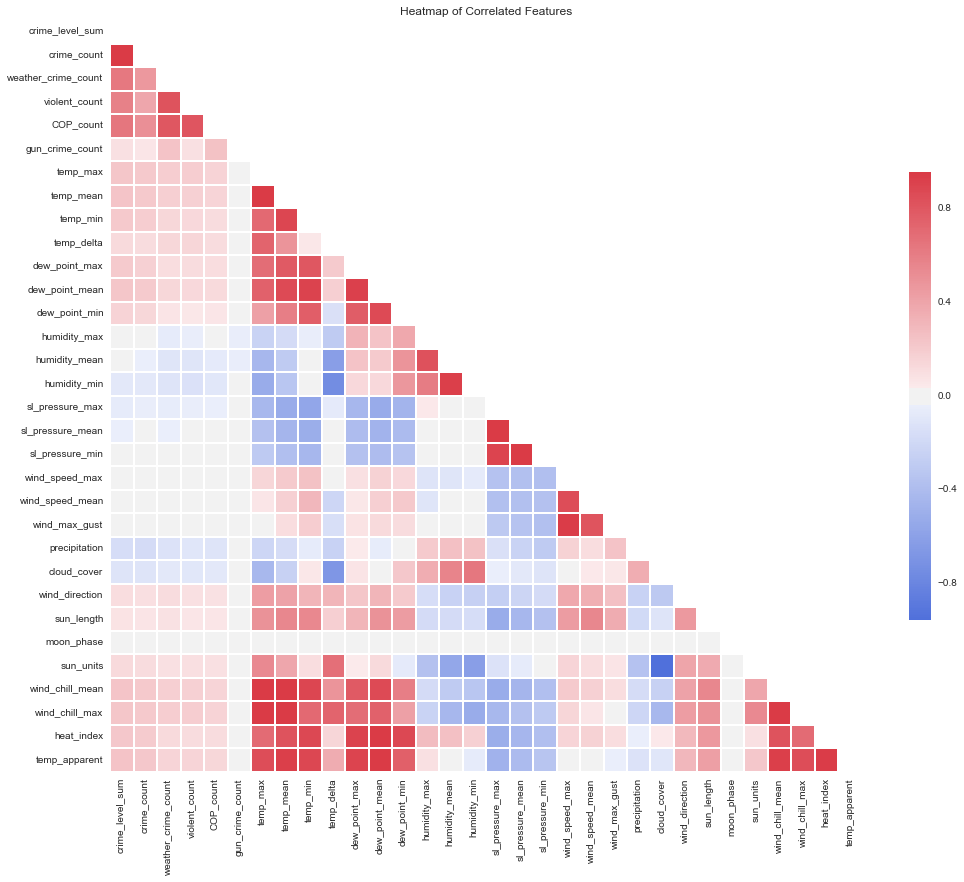

In [10]:
# look at correlated features to see if I can drop any (before I impute any missing values)
# Thanks Michelle
# create correlation heatmap - modified from https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('Heatmap of Correlated Features')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

#### Several different combinations that can be tried

In [11]:
# All numeric features + 
all_features = ['temp_max', 'temp_mean', 'temp_min',
       'temp_delta',  'dew_point_mean', 
       'humidity_mean', 'sl_pressure_mean',
       'wind_chill_max', 'wind_chill_mean', 'winter',
       'wind_speed_max', 'wind_speed_mean', 'precipitation', 'cloud_cover',
       'wind_direction', 'sun_length', 'moon_phase',
       'sun_units', 'end_of_week', 'rain','temp_apparent', 'heat_index']

In [ ]:
# Add Features slowly
temp_features = [ 'temp_mean', 'humidity_mean', 'sl_pressure_mean',
            'wind_speed_mean', 'cloud_cover', 'sun_length',
           'wind_chill_mean', 'heat_index', 'temp_apparent',
           'dayofweek']

In [62]:
# Min weather features + 
min_features = ['temp_max', 'temp_delta','humidity_mean','wind_speed_mean']

In [125]:
# Min weather features + sum and clouds
min_plus_features = ['temp_max', 'temp_delta','humidity_mean','wind_speed_mean',
            'sun_length','cloud_cover','precipitation']

In [172]:
# Min weather features + sum and clouds + halos
halos_features = ['temp_max', 'temp_delta','humidity_mean','wind_speed_mean',
            'sun_length','cloud_cover','precipitation',
            'wind_chill_mean',  'heat_index']

In [246]:
# Day and date info only
date_features = [ 'dayofweek', 'month', 'day']
      

In [12]:
# Current best combination to run
old_best_features = ['temp_mean', 'temp_delta', 'dew_point_mean', 'humidity_mean', 'sl_pressure_mean',
            'wind_speed_mean', 'cloud_cover', 'wind_direction', 'sun_length',
            'wind_chill_mean', 'heat_index', 'temp_apparent',
            'rain', 'dayofweek', 'month', 'day']


#### The Current set of features to run

In [517]:
# min + day and rain
features = [ 'temp_max', 'temp_delta','humidity_mean','wind_speed_mean',
            'dayofweek', 'month', 'day', 'rain']
      

### Choose which Crime Variable to train to

In [518]:
# Which class to train to
#crime_variable = 'crime_count'
#crime_variable = 'violent_count'
#crime_variable = 'crime_level_sum'
crime_variable = 'COP_count'

### Which dummy feature to drop if categoricals are in the feature set

In [519]:
#dummy_drop = ['dayofweek_monday']
#dummy_drop = ['dayofweek_monday', 'month_1', 'rain_False', 'day_3']
dummy_drop = ['dayofweek_monday', 'month_1', 'day_3', 'rain_False']
#dummy_drop = ['rain_False', 'end_of_week_False']

## Prepare data for train/Test

In [520]:
# split into data and class  X, y
X, y = data[features], data[crime_variable]
X.head()

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek,month,day,rain
2011-02-19,45,5,83,6,saturday,2,19,True
2005-01-13,46,5,94,4,thursday,1,13,False
2007-01-12,46,9,49,18,friday,1,12,False
2008-01-24,46,5,82,10,thursday,1,24,True
2009-12-09,46,10,71,7,wednesday,12,9,False


### Create the dummies from the categorical features

In [521]:
# use get_dummies to convert categoricals into binary features
X = pd.get_dummies(X)
X.head(2)

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,...,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,rain_False,rain_True
2011-02-19,45,5,83,6,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2005-01-13,46,5,94,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [522]:
# save the full list if features including the new dummies
# will be needed to create the forecast data frame to run through predictions
full_features = X.columns

In [523]:
# Drop one feature for each categorical
X.drop(dummy_drop, axis=1, inplace=True)
X.head(2)

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek_friday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,rain_True
2011-02-19,45,5,83,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2005-01-13,46,5,94,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [524]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4712 entries, 2011-02-19 to 2010-08-24
Data columns (total 52 columns):
temp_max               4712 non-null int64
temp_delta             4712 non-null int64
humidity_mean          4712 non-null int64
wind_speed_mean        4712 non-null int64
dayofweek_friday       4712 non-null float64
dayofweek_saturday     4712 non-null float64
dayofweek_sunday       4712 non-null float64
dayofweek_thursday     4712 non-null float64
dayofweek_tuesday      4712 non-null float64
dayofweek_wednesday    4712 non-null float64
month_2                4712 non-null float64
month_3                4712 non-null float64
month_4                4712 non-null float64
month_5                4712 non-null float64
month_6                4712 non-null float64
month_7                4712 non-null float64
month_8                4712 non-null float64
month_9                4712 non-null float64
month_10               4712 non-null float64
month_11               4712 non-null

### Split into Test and Training

In [525]:
# Split up data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [526]:
# Standardize data if needed
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [527]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

### Scoring Metric

In [528]:
# Choose the scoring metric
scoring='mean_absolute_error'
#scoring='median_absolute_error'
#scoring='r2'

## Dummy Regressor
- used to compair models to the dummy, which just chooses the mean everytime.

[[back to top](#Sections)]


In [529]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train_std, y_train)
scores = cross_val_score(dummy_model, X_train_std, y_train, scoring=scoring, cv=cv)
print('CV MEA {}, Average MEA {}'.format(scores, scores.mean()))

CV MEA [-8.9414862  -8.2521042  -8.79256987 -8.64640282 -8.89513309 -8.24738333
 -8.7181084  -8.80883909 -8.9949303  -8.63857767], Average MEA -8.69355349688


In [530]:
# Get Mean Error of the test set
results.loc['dummy',scoring] = mean_absolute_error(y_test, dummy_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['dummy',scoring]   

Mean Absolute Error =  8.5300068905


In [531]:
# Check the Speed of esimator
time = %timeit -o dummy_model.predict(X_test_std)
print time
results.loc['dummy','time'] = time.best * 1000000

10000 loops, best of 3: 51.5 µs per loop


## Random Forests

[[back to top](#Sections)]


In [532]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [533]:
ests = range(80,161,20)
for est in ests:
    model = RandomForestRegressor(n_estimators = est)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
    print('n_est {}, CV MAE {}, Average MAE {}'.format(est, scores, scores.mean() * -1))

n_est 80, CV MAE [-8.60135942 -8.24502653 -8.62032493 -8.43660477 -8.63103448], Average MAE 8.50687002653
n_est 100, CV MAE [-8.57790451 -8.25332891 -8.66590186 -8.50940318 -8.58913793], Average MAE 8.51913527851
n_est 120, CV MAE [-8.5632405  -8.20902962 -8.65473033 -8.41341733 -8.5484527 ], Average MAE 8.47777409372
n_est 140, CV MAE [-8.52928192 -8.24573702 -8.60246305 -8.40139257 -8.53646268], Average MAE 8.46306744979
n_est 160, CV MAE [-8.55047248 -8.20423574 -8.62522381 -8.39800232 -8.55542109], Average MAE 8.46667108753


#### Investigate Feature Importance

In [534]:
X_features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': X_features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
2,humidity_mean,0.137213
0,temp_max,0.124767
3,wind_speed_mean,0.113075
1,temp_delta,0.106133
21,day_1,0.026714
5,dayofweek_saturday,0.018959
6,dayofweek_sunday,0.016317
4,dayofweek_friday,0.015957
51,rain_True,0.014818
20,month_12,0.014493


### Choose final parms and fit

In [535]:
RF_model = RandomForestRegressor(n_estimators = 140)
RF_model.fit(X_train, y_train)
scores = cross_val_score(RF_model, X_train, y_train, scoring=scoring, cv=cv)
print('n_est {}, CV MAE {}, MAE accuracy {}'.format(est, scores, scores.mean() * -1))

n_est 160, CV MAE [-8.56988443 -8.16829291 -8.63976885 -8.40385563 -8.62896931], MAE accuracy 8.48215422509


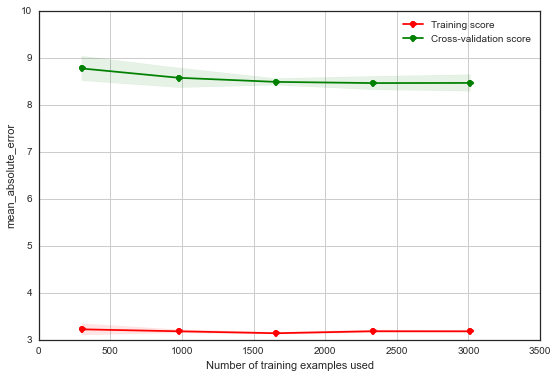

In [536]:
draw_learning_curve(RF_model, X_train, y_train, estimator_titles=['Learning Curve for RF. Best'], 
                    cv=cv, scoring=scoring);

In [537]:
# Add Learning curve comments to result df
results.loc['RF','lc_com'] = '.......'

In [538]:
# Get Mean Error of the test set
results.loc['RF', scoring] = mean_absolute_error(y_test, RF_model.predict(X_test))
print 'Mean Absolute Error = ', results.loc['RF', scoring]   

Mean Absolute Error =  8.1668989547


In [539]:
# Check the Speed of esimator
time = %timeit -o RF_model.predict(X_test)
print time
results.loc['RF','time'] = time.best * 1000000

10 loops, best of 3: 26.6 ms per loop


## SVM


[[back to top](#Sections)]


In [540]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [541]:
#params = {'C': np.linspace(1, 7, 4), 'kernel': ['poly', 'rbf'],
#         'degree': range(1,3), 'gamma': np.linspace(.001, 10, 2)}
# 1 params = {'kernel': ['poly', 'rbf', 'sigmoid', 'linear'], 'degree': range(1,4)}
#min params = {'C': np.linspace(.01, 2, 10), 'kernel': ['linear']}
#np.linspace(.5, 2, 4)
params = {'C': np.linspace(.001, 4, 10), 'kernel': ['linear', 'poly', 'rbf']}
#params = {'C': np.linspace(.001, 2, 10), 'kernel': ['linear', 'poly', 'rbf'], 
#          'gamma': np.linspace(.001, 10, 2), 'degree': range(1,4)}

clf = SVR()
grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(3769, n_iter=5, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf'], 'C': array([  1.00000e-03,   4.45333e-01,   8.89667e-01,   1.33400e+00,
         1.77833e+00,   2.22267e+00,   2.66700e+00,   3.11133e+00,
         3.55567e+00,   4.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [542]:
grid.best_params_

{'C': 0.44533333333333336, 'kernel': 'linear'}

In [543]:
#grid.grid_scores_

In [544]:
SVM_model = grid.best_estimator_

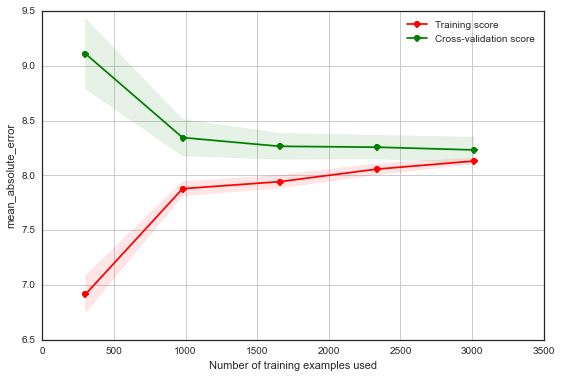

In [545]:
draw_learning_curve(SVM_model, X_train_std, y_train, estimator_titles=['Learning Curve for SVC. Best'], 
                    cv=cv, scoring=scoring);

In [546]:
# Add Learning curve comments to result df
results.loc['SVM','lc_com'] = '.......'

In [547]:
# Get Mean Error of the test set
results.loc['SVM', scoring] = mean_absolute_error(y_test, SVM_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['SVM', scoring]            

Mean Absolute Error =  8.09213740202


In [548]:
# Check the Speed of esimator
time = %timeit -o SVM_model.predict(X_test_std)
print time
results.loc['SVM','time'] = time.best * 1000000

10 loops, best of 3: 156 ms per loop


## Lasso/Ridge

[[back to top](#Sections)]


In [549]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train_std.shape[0], n_iter=20, test_size=0.2, random_state=0)

In [550]:
# using Mean Absolute scoring
parameters = {'alpha': np.linspace(.0001,2,20)}
#parameters = {'alpha': [.2, .3]}

LR = Lasso(normalize=False)
clf = GridSearchCV(LR, parameters, scoring=scoring, cv=cv)
clf.fit(X_train_std, y_train)
clf.best_params_

{'alpha': 0.10535789473684211}

In [551]:
#clf.grid_scores_

In [552]:
LR_model = clf.best_estimator_

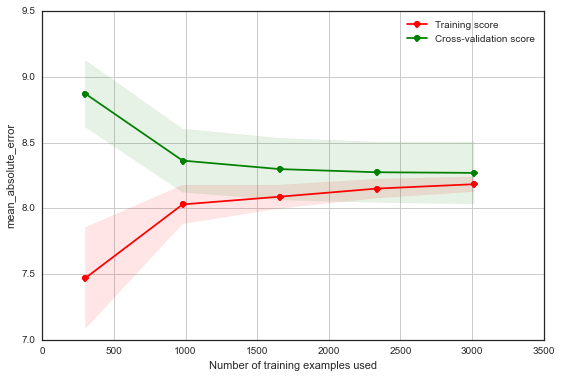

In [553]:
draw_learning_curve(LR_model, X_train_std, y_train, estimator_titles=['Learning Curve for lasso'], 
                    cv=cv, scoring=scoring);

In [554]:
# Add Learning curve comments to result df
results.loc['LR','lc_com'] = '.......'

In [555]:
# Get Mean Error of the test set
results.loc['LR',scoring] = mean_absolute_error(y_test, LR_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['LR', scoring]             

Mean Absolute Error =  7.99669205248


In [556]:
# Check the Speed of esimator
time = %timeit -o LR_model.predict(X_test_std)
print time
results.loc['LR','time'] = time.best * 1000000

The slowest run took 8.53 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 67.6 µs per loop


### Investigate Coefficients

In [557]:
# create a dataframe to show our coefficients
d = {'features': X_test.columns, 'coefficients': LR_model.coef_}
pd.DataFrame(d)

,coefficients,features
0,1.634857,temp_max
1,-0.197354,temp_delta
2,0.039777,humidity_mean
3,-0.222409,wind_speed_mean
4,1.222319,dayofweek_friday
5,1.666803,dayofweek_saturday
6,1.289869,dayofweek_sunday
7,-0.451354,dayofweek_thursday
8,-0.078297,dayofweek_tuesday
9,-0.000000,dayofweek_wednesday


## Results
[[back to top](#Sections)]

In [558]:
models = ['RF', 'SVM', 'LR']

In [559]:
for model in models:
    dif = results.loc['dummy','mean_absolute_error'] - results.loc[model,'mean_absolute_error']
    results.loc[model,'% improvements from dummy'] = dif / results.loc['dummy','mean_absolute_error']

In [560]:
# Display Results of all models
results



,mean_absolute_error,time,lc_com,% improvements from dummy
dummy,8.53001,51.4562,NaN,NaN
RF,8.1669,26638.8,.......,0.042568
SVM,8.09214,155673,.......,0.051333
LR,7.99669,67.6487,.......,0.062522


# Forecast

[[back to top](#Sections)]


## Data source for Forecast
Data was consolidated in Notebook
- This is done in the `'8_get_weather_forcast'` notebook. | Downloaded from Weather Underground and OpenWeatherMap
- Data is written to file. `'forecast_10day.csv'`


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
date|string|Format yyyy-m-d
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
sl_pressure_mean|float64|Mean Sea Level for the day in inches
humidity_mean|int64|Mean Humidity for the day in percentage
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
cloud_cover|int64|Cloud Cover in percentage.
precipitation|float64|Amount is precipitation in inches
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
dew_point_mean|int64|Mean Dewpoint for day on day
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
rain|bool| IS there rain in the forcast
end_of_week|bool|is it Friday or Saturday

In [561]:
forecast = pd.read_csv('forecast_10day.csv', index_col=0)
forecast.head(3)



,date,dayofweek,day,month,year,temp_max,temp_mean,temp_min,temp_delta,sl_pressure_mean,...,winter,rain,sun_length,moon_phase,sun_units,dew_point_mean,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
0,2016-3-10,thursday,10,3,2016,61,58,56,5,30.246103,...,False,True,706.183333,0.044071,56.494667,54.578390,58,61,252.393389,97.670619
1,2016-3-11,friday,11,3,2016,58,55,53,5,29.914481,...,False,True,708.600000,0.078090,56.688000,49.382408,55,58,191.059997,76.296685
2,2016-3-12,saturday,12,3,2016,58,56,55,3,30.274451,...,False,True,711.016667,0.112110,142.203333,49.806332,56,58,194.677835,77.434017


In [562]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 29 columns):
date                10 non-null object
dayofweek           10 non-null object
day                 10 non-null int64
month               10 non-null int64
year                10 non-null int64
temp_max            10 non-null int64
temp_mean           10 non-null int64
temp_min            10 non-null int64
temp_delta          10 non-null int64
sl_pressure_mean    10 non-null float64
humidity_mean       10 non-null int64
wind_speed_max      10 non-null int64
wind_speed_mean     10 non-null int64
cloud_cover         10 non-null int64
precipitation       10 non-null float64
events              10 non-null object
wind_direction      10 non-null int64
owm_status          10 non-null object
end_of_week         10 non-null bool
winter              10 non-null bool
rain                10 non-null bool
sun_length          10 non-null float64
moon_phase          10 non-null float64
sun_units      

## Add Engineered Features

[[back to top](#Sections)]


In [563]:
forecast2 = forecast[features]
forecast2.head()

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek,month,day,rain
0,61,5,85,10,thursday,3,10,True
1,58,5,76,20,friday,3,11,True
2,58,3,74,21,saturday,3,12,True
3,59,5,84,18,sunday,3,13,True
4,58,8,66,13,monday,3,14,True


In [564]:
#data['events'].fillna('No', inplace=True)
#forecast2['events'] = forecast2['events'].astype('category')
forecast2.loc[:,'day'] = forecast2['day'].astype('category')
forecast2.loc[:,'month'] = forecast2['month'].astype('category')
#forecast2['year'] = forecast2['year'].astype('category')
forecast2.loc[:,'dayofweek'] = forecast2['dayofweek'].astype('category')
#forecast2['end_of_week'] = forecast2['end_of_week'].astype('category')
forecast2.loc[:,'rain'] = forecast2['rain'].astype('category')



In [565]:
# use get_dummies to convert categoricals into binary features
forecast2 = pd.get_dummies(forecast2)
forecast2.head(2)

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,...,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,rain_False,rain_True
0,61,5,85,10,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,58,5,76,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### The prediction models are expecting all dummy variables
The forecast will not have all dummies beacause not all months and days are in the 10 day forecast


In [566]:
full_features

Index([u'temp_max', u'temp_delta', u'humidity_mean', u'wind_speed_mean',
       u'dayofweek_friday', u'dayofweek_monday', u'dayofweek_saturday',
       u'dayofweek_sunday', u'dayofweek_thursday', u'dayofweek_tuesday',
       u'dayofweek_wednesday', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'day_1', u'day_2', u'day_3', u'day_4',
       u'day_5', u'day_6', u'day_7', u'day_8', u'day_9', u'day_10', u'day_11',
       u'day_12', u'day_13', u'day_14', u'day_15', u'day_16', u'day_17',
       u'day_18', u'day_19', u'day_20', u'day_21', u'day_22', u'day_23',
       u'day_24', u'day_25', u'day_26', u'day_27', u'day_28', u'day_29',
       u'day_30', u'day_31', u'rain_False', u'rain_True'],
      dtype='object')

In [567]:
# Find out the missing columns
missing_columns = set(full_features) - set(forecast2.columns)
missing_columns

{'day_1',
 'day_2',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_3',
 'day_30',
 'day_31',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'month_1',
 'month_10',
 'month_11',
 'month_12',
 'month_2',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9'}

In [568]:
# create the missing columns filled with 0s
for col in missing_columns:
    forecast2.loc[:,col] = 0


In [569]:
# Drop one feature for each categorical
# drop on day of week
forecast2.drop(dummy_drop, axis=1, inplace=True)
forecast2.head(2)

,temp_max,temp_delta,humidity_mean,wind_speed_mean,dayofweek_friday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,...,day_23,day_22,day_25,day_24,day_27,day_26,day_29,day_28,month_8,day_7
0,61,5,85,10,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,58,5,76,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [570]:
print 'Do the two Datasets have matching Features? : ', (set(X) == set(forecast2)) 

Do the two Datasets have matching Features? :  True


In [571]:
# Data Frame for results
prediction = forecast[['dayofweek', 'month', 'day','year', 'temp_max', 'events']]

In [572]:
# Standardize the data
forecast2_std = stdsc.transform(forecast2)

### Run Models on Prediction

[[back to top](#Sections)]


In [573]:
prediction.loc[:,'prediction_dummy'] = dummy_model.predict(forecast2_std)
prediction.loc[:,'prediction_RF'] = RF_model.predict(forecast2)
prediction.loc[:,'prediction_SVM'] = SVM_model.predict(forecast2_std)
prediction.loc[:,'prediction_LR'] = LR_model.predict(forecast2_std)
prediction

,dayofweek,month,day,year,temp_max,events,prediction_dummy,prediction_RF,prediction_SVM,prediction_LR
0,thursday,3,10,2016,61,Rain,60.739453,73.035714,71.375672,70.581508
1,friday,3,11,2016,58,Rain,60.739453,72.028571,74.313201,72.396131
2,saturday,3,12,2016,58,Rain,60.739453,79.828571,73.493702,73.544096
3,sunday,3,13,2016,59,Rain,60.739453,72.300000,71.018511,71.414991
4,monday,3,14,2016,58,Partly Cloudy,60.739453,69.828571,64.237149,65.805211
5,tuesday,3,15,2016,60,Clear,60.739453,70.900000,65.291169,66.681323
6,wednesday,3,16,2016,65,Clear,60.739453,59.107143,60.174791,60.180884
7,thursday,3,17,2016,66,Clear,60.739453,59.200000,60.061323,59.286971
8,friday,3,18,2016,66,Clear,60.739453,56.764286,65.139014,62.968342
9,saturday,3,19,2016,66,Partly Cloudy,60.739453,62.021429,64.188578,62.326056


In [574]:
prediction.loc[:,'mean'] = (prediction['prediction_RF'] + prediction['prediction_SVM'] + prediction['prediction_LR']) / 3
prediction

,dayofweek,month,day,year,temp_max,events,prediction_dummy,prediction_RF,prediction_SVM,prediction_LR,mean
0,thursday,3,10,2016,61,Rain,60.739453,73.035714,71.375672,70.581508,71.664298
1,friday,3,11,2016,58,Rain,60.739453,72.028571,74.313201,72.396131,72.912634
2,saturday,3,12,2016,58,Rain,60.739453,79.828571,73.493702,73.544096,75.622123
3,sunday,3,13,2016,59,Rain,60.739453,72.300000,71.018511,71.414991,71.577834
4,monday,3,14,2016,58,Partly Cloudy,60.739453,69.828571,64.237149,65.805211,66.623644
5,tuesday,3,15,2016,60,Clear,60.739453,70.900000,65.291169,66.681323,67.624164
6,wednesday,3,16,2016,65,Clear,60.739453,59.107143,60.174791,60.180884,59.820939
7,thursday,3,17,2016,66,Clear,60.739453,59.200000,60.061323,59.286971,59.516098
8,friday,3,18,2016,66,Clear,60.739453,56.764286,65.139014,62.968342,61.623881
9,saturday,3,19,2016,66,Partly Cloudy,60.739453,62.021429,64.188578,62.326056,62.845354


In [575]:
data.describe().index.values

array(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype=object)

In [576]:
data.describe(percentiles=[.30, .70]) 



,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,temp_max,temp_mean,temp_min,temp_delta,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
count,4712.000000,4712.000000,4712.00000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,...,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000
mean,718.853141,381.088285,77.77101,39.665110,60.673387,3.312394,65.824278,58.642827,51.158531,14.665747,...,0.047507,44.982173,246.217317,732.071806,0.512521,406.461629,58.642827,65.824278,216.634454,92.981840
std,85.498010,45.021208,13.70592,9.156712,11.106615,2.132232,8.388321,6.517580,5.697210,5.860592,...,0.192233,28.923517,71.538046,106.860863,0.288817,223.508617,6.517580,8.388321,60.170987,18.330431
min,292.000000,148.000000,18.00000,6.000000,18.000000,0.000000,45.000000,40.000000,32.000000,2.000000,...,0.000000,0.000000,1.000000,575.300000,0.012958,0.000000,40.000000,45.000000,55.000000,38.602076
30%,674.000000,358.000000,70.00000,35.000000,55.000000,2.000000,61.000000,55.000000,48.000000,11.000000,...,0.000000,25.000000,251.000000,647.621667,0.313055,264.590200,55.000000,61.000000,182.840227,82.448310
50%,717.000000,381.000000,77.00000,39.000000,60.000000,3.000000,65.000000,59.000000,52.000000,14.000000,...,0.000000,50.000000,273.000000,733.458333,0.512097,412.401167,59.000000,65.000000,219.701946,92.643745
70%,761.000000,404.000000,84.00000,44.000000,66.000000,4.000000,70.000000,62.000000,55.000000,17.000000,...,0.000000,62.000000,287.000000,817.625000,0.712135,546.989050,62.000000,70.000000,251.499201,102.705303
max,1008.000000,499.000000,158.00000,81.000000,122.000000,16.000000,99.000000,82.000000,69.000000,39.000000,...,3.430000,100.000000,359.000000,885.650000,1.012482,885.633333,82.000000,99.000000,429.726716,161.898428


In [577]:
limit_30 = data.describe(percentiles=[.30, .70]).loc['30%', crime_variable]               
#limit_30 = lr_res.describe(percentiles=[.30, .70]).loc['30%', 0]               
limit_30

55.0

In [578]:
limit_70 = data.describe(percentiles=[.30, .70]).loc['70%', crime_variable]   
#limit_70 = lr_res.describe(percentiles=[.30, .70]).loc['70%', 0]   
limit_70

66.0

In [579]:
def set_class(predict):
    if predict >= limit_70:
        level = 'High'
    elif predict > limit_30:
        level = 'Average'
    else :
        level = 'Low'
    return level

In [584]:
prediction.loc[:, 'crime_stage'] = prediction['mean'].apply(set_class)
prediction[['dayofweek', 'month', 'day','year', 'temp_max', 'events', 'crime_stage']]

,dayofweek,month,day,year,temp_max,events,crime_stage
0,thursday,3,10,2016,61,Rain,High
1,friday,3,11,2016,58,Rain,High
2,saturday,3,12,2016,58,Rain,High
3,sunday,3,13,2016,59,Rain,High
4,monday,3,14,2016,58,Partly Cloudy,High
5,tuesday,3,15,2016,60,Clear,High
6,wednesday,3,16,2016,65,Clear,Average
7,thursday,3,17,2016,66,Clear,Average
8,friday,3,18,2016,66,Clear,Average
9,saturday,3,19,2016,66,Partly Cloudy,Average


In [583]:
data[crime_variable].apply(set_class).value_counts()

Average    1689
Low        1557
High       1466
Name: COP_count, dtype: int64

# Working Area.....

In [ ]:
# look at predictions
lr_res = pd.DataFrame(LR_model.predict(X_test_std))
lr_res.describe()

## PCA -  Try reducing features

In [ ]:
X_train.shape

In [ ]:
pca = PCA(n_components=0.8, whiten=True)
#pca = PCA(n_components=22, whiten=True)

In [ ]:
# your code here
pca.fit(X_train_std)
pca.explained_variance_

In [ ]:
var = pca.explained_variance_ratio_
var

In [ ]:
# your answer here
plt.plot(var)
plt.ylabel('Variance Ratio')
plt.show()

In [ ]:
X_train_pca = pd.DataFrame(pca.transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))

In [ ]:
print X_test_pca.shape, X_train_pca.shape

## LR

### run with X_train_pca or with X_2

In [ ]:
type(X_3),type(y_2)

In [ ]:
X_3[0:2]

In [ ]:
y_2.head()

In [ ]:
#X_2.reset_index()

#y_2.reset_index().drop(['index'], axis=1)
y_3 = y_2.reset_index()

y_3.head()

In [ ]:
y_4 = y_3['crime_count']

y_4.head()

In [ ]:
X_3 = X_2.reset_index()
X_3.head()

In [ ]:
X_3.drop('index', axis=1, inplace=True)
X_3.head()

In [ ]:
X_3.shape, y_4.shape

In [ ]:
# using Mean Absolute scoring
parameters = {'alpha': np.linspace(.01,1,20)}
LR_2 = Lasso(normalize=False)
clf_2 = GridSearchCV(LR_2, parameters, scoring=scoring, cv=cv)
clf_2.fit(X_2_std, y_2)
clf_2.best_params_

In [ ]:
LR_2_model = clf_2.best_estimator_

In [ ]:
draw_learning_curve(LR_2_model, X_2, y_2, estimator_titles=['Learning Curve for lasso'], 
                    cv=cv, scoring=scoring);

In [ ]:
LR_2_model.score(X_test, y_test)


In [ ]:
# create a dataframe to show our coefficients
d = {'features': X_test_pca.columns, 'coefficients': LR_2_model.coef_}
pd.DataFrame(d)

### SVM

In [ ]:
params = {'C': np.linspace(.01, 5, 4), 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'], 'degree': range(1,4), 'gamma': np.linspace(.01, .03, 4)}


clf_pca = SVR()
grid_pca = GridSearchCV(clf_pca, params, cv=cv, scoring=scoring, n_jobs=-1)
grid_pca.fit(X_train_pca, y_train)

In [ ]:
grid_pca.best_params_

In [ ]:
SVM_model_pca = grid_pca.best_estimator_
draw_learning_curve(SVM_model_pca, X_train_pca, y_train, estimator_titles=['Learning Curve for SVC. Best'], 
                    cv=cv, scoring=scoring);

In [ ]:
print  SVM_model_pca.score(X_test_pca, y_test)


In [ ]:
# Get Mean Error of the test set
print mean_absolute_error(y_test, SVM_model_pca.predict(X_test_pca))
  